# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

## Inspecting the data

any comment about data dimensionality/distribution goes here

In [14]:
import pandas as pd
import numpy as np
import os

# Suppress TensorFlow logging warnings to reduce console output clutter
# This is useful for improving the readability of logs during model training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_data(path, train=True):
    """
    Load and preprocess data from a specified CSV file.

    Parameters:
    path (str): The file path to the CSV data.
    train (bool): A flag indicating whether the data is for training (True) or testing (False).
                  If True, the function will return features and labels; otherwise, it returns the features and IDs.

    Returns:
    tuple: A tuple containing:
        - np.ndarray: A 2D array of features (X).
        - np.ndarray: A 1D array of labels (y) if train is True, otherwise a 1D array of IDs.
    """

    # Read CSV file into a DataFrame, using ISO-8859-2 encoding to handle special characters
    df = pd.read_csv(path, encoding="ISO-8859-2")
    
    # Clip the values in the EDUCATION and MARRIAGE columns to ensure they fall within specified ranges
    # EDUCATION: [1, 4] and MARRIAGE: [1, 3] are considered valid categories
    df['EDUCATION'] = df['EDUCATION'].clip(lower=1, upper=4)
    df['MARRIAGE'] = df['MARRIAGE'].clip(lower=1, upper=3)
    
    # Clip the values for payment columns PAY_0 to PAY_6 to restrict them to the range [0, 9]
    # This ensures that all payment values are valid and within expected limits
    for col in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
        df[col] = df[col].clip(lower=0, upper=9)
        
    # TODO: DA VERIFICARE CORRETTEZZA!
    df.drop(["ID", "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
         "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
         "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4",
         "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2",
         "PAY_AMT3"], axis=1, inplace=True)

    
    # For training data, shuffle the DataFrame and separate features and labels
    # The random_state ensures reproducibility of results
    if train:
        data = df.sample(frac=1, random_state=42).values
        return data[:, 1:-1].astype(np.float32), data[:, -1]
    
    # For testing data, return the features and IDs without shuffling
    return df.iloc[:, 1:].values.astype(np.float32), df.iloc[:, 0].astype(str)

# Load training and test datasets
X_train, labels = load_data('./train.csv')
X_test, ids = load_data('./test.csv', train=False)

# Print the dimensions of the training set and the number of features
# This provides an overview of the dataset's structure
print(f"Training set dimensions: {X_train.shape}\nFeatures count: {X_train.shape[1]}")
print("\nFirst 5 training samples:\n", pd.DataFrame(X_train).head())

# Display the distribution of labels in the training set
# This helps in understanding class balance which is critical for modeling
print("\nLabels distribution:\n", pd.Series(labels).value_counts())

# Check for missing values in the training set
# Identifying missing values is essential for ensuring data quality before model training
print("\nMissing values:\n", pd.read_csv('./train.csv').isnull().sum())

# Output summary statistics for the training dataset
# This provides insights into data characteristics such as mean, min, max, etc.
print("\nSummary statistics:\n", pd.read_csv('./train.csv').describe())

# Print dimensions of the test set to confirm data loading
print("\nTest set dimensions:", X_test.shape)

Training set dimensions: (25500, 3)
Features count: 3

First 5 training samples:
         0       1       2
0  2000.0  1000.0  2000.0
1  5000.0  1200.0   980.0
2   572.0   584.0   400.0
3   700.0  1700.0     0.0
4     0.0     0.0     0.0

Labels distribution:
 0    19815
1     5685
Name: count, dtype: int64

Missing values:
 ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
P

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

Missing values:
 ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


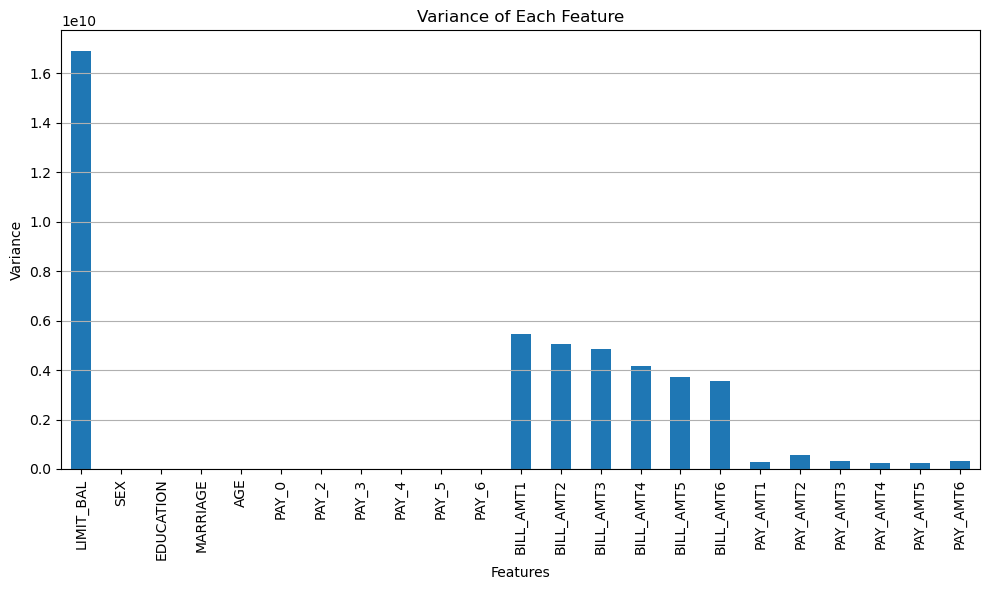

Shapes -> Train: (17850, 23), Val: (7650, 23), Test: (4500, 23), Encoded Train: (17850, 2), Encoded Val: (7650, 2)


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def preprocess_data(X, scaler=None):
    if scaler is None:
        scaler = StandardScaler().fit(X)
    return scaler.transform(X), scaler

def preprocess_labels(y, encoder=None):
    if encoder is None:
        encoder = LabelEncoder().fit(y)
    return to_categorical(encoder.transform(y)), encoder

# Load data
df_train = pd.read_csv('./train.csv')

# Separare le features e le etichette
labels_raw = df_train['default payment next month']  # Sostituisci con il nome corretto della colonna target

columns_to_drop = ["ID"]

# columns_to_drop = ["ID", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

# Creare il DataFrame delle features
X_train_raw = df_train.drop(columns=columns_to_drop + ['default payment next month'])  # Escludere la colonna target

# Check for missing values
print("Missing values:\n", df_train.isnull().sum())

# Plot variance
plt.figure(figsize=(10, 6))
df_train.var().plot(kind='bar')
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, labels_raw, 
                                                  test_size=0.3, random_state=42, stratify=labels_raw)

# Scale features and encode labels
X_train_scaled, scaler = preprocess_data(X_train)
X_val_scaled, _ = preprocess_data(X_val, scaler)
y_train_encoded, encoder = preprocess_labels(y_train)
y_val_encoded, _ = preprocess_labels(y_val, encoder)

# Preprocess test data
X_test_raw = pd.read_csv('./test.csv').drop(columns=columns_to_drop)
X_test_scaled, _ = preprocess_data(X_test_raw, scaler)

# Print shapes of datasets
print(f"Shapes -> Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}, "
      f"Encoded Train: {y_train_encoded.shape}, Encoded Val: {y_val_encoded.shape}")

## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

In [16]:

from keras.src.utils import plot_model
from keras.src.optimizers import Adam
from keras.src.layers import Dense, BatchNormalization, Dropout
from keras import Sequential, Input
# Importing necessary libraries and modules from Keras and Scikit-learn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Initialize a StandardScaler object for feature scaling
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)  

# Transform the validation data using the same scaler (to avoid data leakage)
X_val_scaled = scaler.transform(X_val) 

def build_model(input_shape):
    """
    Builds a sequential neural network model.

    Parameters:
    input_shape (int): The number of input features.

    Returns:
    model (Sequential): A compiled Keras Sequential model.
    """
    model = Sequential()  # Initialize a Sequential model
    model.add(Input(shape=(input_shape,)))  # Input layer with the specified shape

    # First hidden layer with 256 units, ReLU activation, and L2 regularization
    model.add(Dense(256, activation='relu', kernel_regularizer='l2')) 
    model.add(BatchNormalization())  # Batch normalization to stabilize training
    model.add(Dropout(0.4))  # Dropout layer for regularization to prevent overfitting

    # Second hidden layer with 128 units, ReLU activation, and L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())  # Batch normalization
    model.add(Dropout(0.4))  # Dropout layer

    # Third hidden layer with 64 units, ReLU activation, and L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())  # Batch normalization
    model.add(Dropout(0.4))  # Dropout layer

    # Fourth hidden layer with 32 units, Leaky ReLU activation, and L2 regularization
    model.add(Dense(32, activation='leaky_relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())  # Batch normalization

    # Output layer with a single unit and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))  

    # Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model  # Return the compiled model

# Determine the input shape based on the scaled training data
input_shape = X_train_scaled.shape[1]  
# Build the model with the defined input shape
model = build_model(input_shape)

# Set batch size and number of epochs for training
batch_size = 64
epochs = 10

# Outputs a model summary table
model.summary()

# Define an EarlyStopping callback to halt training when validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define a ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

class ProgressBar(Callback):
    """
    Custom callback to display training progress.

    Inherits from Keras Callback to provide additional functionality during training.
    """
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch  # Store the current epoch number
    
    def on_epoch_end(self, epoch, logs=None):
        # Format and print training metrics at the end of each epoch
        metrics = (f"Epoch {self.epoch + 1}/{self.params['epochs']} - "
                   f"Loss: {logs['loss']:.4f} - "
                   f"Val Loss: {logs['val_loss']:.4f} - "
                   f"Accuracy: {logs['accuracy']:.4f} - "
                   f"Val Accuracy: {logs['val_accuracy']:.4f}")
        print("\r" + metrics, end='')  # Print metrics on the same line

# Train the model using the fit method with training and validation data
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr, ProgressBar()],
                    verbose=1)  # Set verbose to 0 to suppress output

# Evaluate the model's performance on the validation set
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

# Print results for validation loss and accuracy
print()
print("\nRESULTS:")
print(f"{'Validation Loss:':<20} {val_loss:.4f}")
print(f"{'Validation Accuracy:':<20} {val_accuracy:.4f}")

# Generate predictions on the validation set and convert probabilities to binary labels
y_pred_prob = model.predict(X_val_scaled, verbose=0) 
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score to evaluate the model's performance
f1 = f1_score(y_val, y_pred)  
print(f"{'F1 Score:':<20} {f1:.4f}")  # Print the F1 score

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 50,369 (196.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5301 - loss: 4.1722 - val_accuracy: 0.8005 - val_loss: 3.6435 - learning_rate: 1.0000e-04
Epoch 2/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6440 - loss: 3.6758 - val_accuracy: 0.8082 - val_loss: 3.2760 - learning_rate: 1.0000e-04
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7129 - loss: 3.2915 - val_accuracy: 0.8119 - val_loss: 2.9473 - learning_rate: 1.0000e-04
Epoch 4/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7570 - loss: 2.9409 - val_accuracy: 0.8077 - val_loss: 2.6465 - learning_rate: 1.0000e-04
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7789 - loss: 2.6387 - val_accuracy: 0.8072 - val_loss: 2.3781 - learning_rate: 1.0000e-04
Epoch 6/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7948 - loss: 2.3612 - val_accuracy: 0.8075 - val_loss: 2.1402 - learning_rate: 1.0000e-04
Epoch 7/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 

KeyboardInterrupt: 

In [7]:

from keras.src.utils import plot_model
from keras.src.optimizers import Adam
from keras.src.layers import Dense, BatchNormalization, Dropout
from keras import Sequential, Input
# Importing necessary libraries and modules from Keras and Scikit-learn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Initialize a StandardScaler object for feature scaling
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)  

# Transform the validation data using the same scaler (to avoid data leakage)
X_val_scaled = scaler.transform(X_val) 

def build_model(input_shape):
    """
    Builds a sequential neural network model.

    Parameters:
    input_shape (int): The number of input features.

    Returns:
    model (Sequential): A compiled Keras Sequential model.
    """
    model = Sequential()  # Initialize a Sequential model
    model.add(Input(shape=(input_shape,)))  # Input layer with the specified shape

    # First hidden layer with 256 units, ReLU activation, and L2 regularization
    model.add(Dense(256, activation='relu', kernel_regularizer='l2')) 

    # Second hidden layer with 128 units, ReLU activation, and L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))


    # Third hidden layer with 64 units, ReLU activation, and L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))

    # Fourth hidden layer with 32 units, Leaky ReLU activation, and L2 regularization
    model.add(Dense(32, activation='relu', kernel_regularizer='l2'))

    # Output layer with a single unit and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))  

    # Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model  # Return the compiled model

# Determine the input shape based on the scaled training data
input_shape = X_train_scaled.shape[1]  
# Build the model with the defined input shape
model = build_model(input_shape)

# Set batch size and number of epochs for training
batch_size = 64
epochs = 200

# Outputs a model summary table
model.summary()

# Define an EarlyStopping callback to halt training when validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define a ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

class ProgressBar(Callback):
    """
    Custom callback to display training progress.

    Inherits from Keras Callback to provide additional functionality during training.
    """
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch  # Store the current epoch number
    
    def on_epoch_end(self, epoch, logs=None):
        # Format and print training metrics at the end of each epoch
        metrics = (f"Epoch {self.epoch + 1}/{self.params['epochs']} - "
                   f"Loss: {logs['loss']:.4f} - "
                   f"Val Loss: {logs['val_loss']:.4f} - "
                   f"Accuracy: {logs['accuracy']:.4f} - "
                   f"Val Accuracy: {logs['val_accuracy']:.4f}")
        print("\r" + metrics, end='')  # Print metrics on the same line

# Train the model using the fit method with training and validation data
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr, ProgressBar()],
                    verbose=1)  # Set verbose to 0 to suppress output

# Evaluate the model's performance on the validation set
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

# Print results for validation loss and accuracy
print()
print("\nRESULTS:")
print(f"{'Validation Loss:':<20} {val_loss:.4f}")
print(f"{'Validation Accuracy:':<20} {val_accuracy:.4f}")

# Generate predictions on the validation set and convert probabilities to binary labels
y_pred_prob = model.predict(X_val_scaled, verbose=0) 
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score to evaluate the model's performance
f1 = f1_score(y_val, y_pred)  
print(f"{'F1 Score:':<20} {f1:.4f}")  # Print the F1 score

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,409 (193.00 KB)

 Trainable params: 49,409 (193.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6989 - loss: 3.6457 - val_accuracy: 0.7993 - val_loss: 2.6429 - learning_rate: 1.0000e-04
Epoch 2/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8009 - loss: 2.4062 - val_accuracy: 0.8075 - val_loss: 1.8136 - learning_rate: 1.0000e-04
Epoch 3/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8072 - loss: 1.6690 - val_accuracy: 0.8094 - val_loss: 1.3022 - learning_rate: 1.0000e-04
Epoch 4/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8132 - loss: 1.2075 - val_accuracy: 0.8110 - val_loss: 0.9891 - learning_rate: 1.0000e-04
Epoch 5/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8103 - loss: 0.9340 - val_accuracy: 0.8119 - val_loss: 0.7980 - learning_rate: 1.0000e-04
Epoch 6/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8137 - loss: 0.7627 - val_accuracy: 0.8093 - val_loss: 0.6820 - learning_rate: 1.0000e-04
Epoch 7/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

In [57]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Step 1: Generate predictions on the validation set
y_val_pred_prob = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Confusion Matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(confusion)

# Step 3: Classification Report
class_report = classification_report(y_val, y_val_pred, target_names=["No Default", "Default"])
print("Classification Report:")
print(class_report)

# Step 4: Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
Confusion Matrix:
[[5530  415]
 [1040  665]]
Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.93      0.88      5945
     Default       0.62      0.39      0.48      1705

    accuracy                           0.81      7650
   macro avg       0.73      0.66      0.68      7650
weighted avg       0.79      0.81      0.79      7650

ROC AUC Score: 0.7469


## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [58]:
# Load the test data
X_test, test_ids = load_data(url_test, train=False)

# Preprocess the test data
X_test_scaled, _ = preprocess_data(X_test)

# Step 1: Make predictions on the test set
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Create a DataFrame for submission or further analysis
results = pd.DataFrame({
    'Default_Prediction': y_test_pred.flatten()
})

# Step 3: Save predictions to a CSV file (optional)
results.to_csv('test_predictions.csv', index=False, header=False)

# Display predictions
print("Predictions on Test Set:")
print(results.head())


NameError: name 'url_test' is not defined

# OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify you prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).